# FORECASTING MELI COSTS USING A SARIMA MODEL

## OBJECTIVE

In order to understand how a SARIMA model works, we will be using the **statsmodel** package implementation (https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) to try to forecast MercadoLibre (MELI) EC2 costs using a dataset with hourly data from operations of EC2 instance purchases during May 2019.

## PACKAGES

In [ ]:
import os # for handling files
import matplotlib
import matplotlib.pyplot as plt
import warnings # for handling warning messages
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import itertools # collection of tools for handling iterators
import numpy as np
import pandas as pd
import statsmodels.api as sm
'''
provides classes and functions for the estimation of many different
statistical models, as well as for conducting statistical tests, 
and statistical data exploration.
'''
import pmdarima as pm 

'''
Pmdarima is a statistical library
'''

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## DATA PROCESSING
### LOADING

In [ ]:
costs_time_series_path = "meli_ec2_blended_cost_may_2019.xlsx"
df_costs = pd.read_excel(costs_time_series_path)

In [91]:
df_costs.head(5)

,y
ds,
2019-05-01 00:00:00,797.630194
2019-05-01 01:00:00,785.197282
2019-05-01 02:00:00,786.322356
2019-05-01 03:00:00,765.981622
2019-05-01 04:00:00,755.727199


### INDEXING 

We use time data as an index for our dataframe

In [ ]:
df_costs = df_costs.set_index('ds')

### RESAMPLING 
We resample data using a daily frequency

In [ ]:
df_costs_monthly = df_costs['y'].resample('D').mean()

In [92]:
df_costs_monthly.head(5)

ds
2019-05-01    774.111453
2019-05-02    804.738605
2019-05-03    816.846227
2019-05-04    773.392662
2019-05-05    812.632086
Freq: D, Name: y, dtype: float64

### VISUALIZING

#### EXPLORATORY VISUALIZATION

We make an exploratory visulization of data using pyplot.

First, we show a plot of the raw data

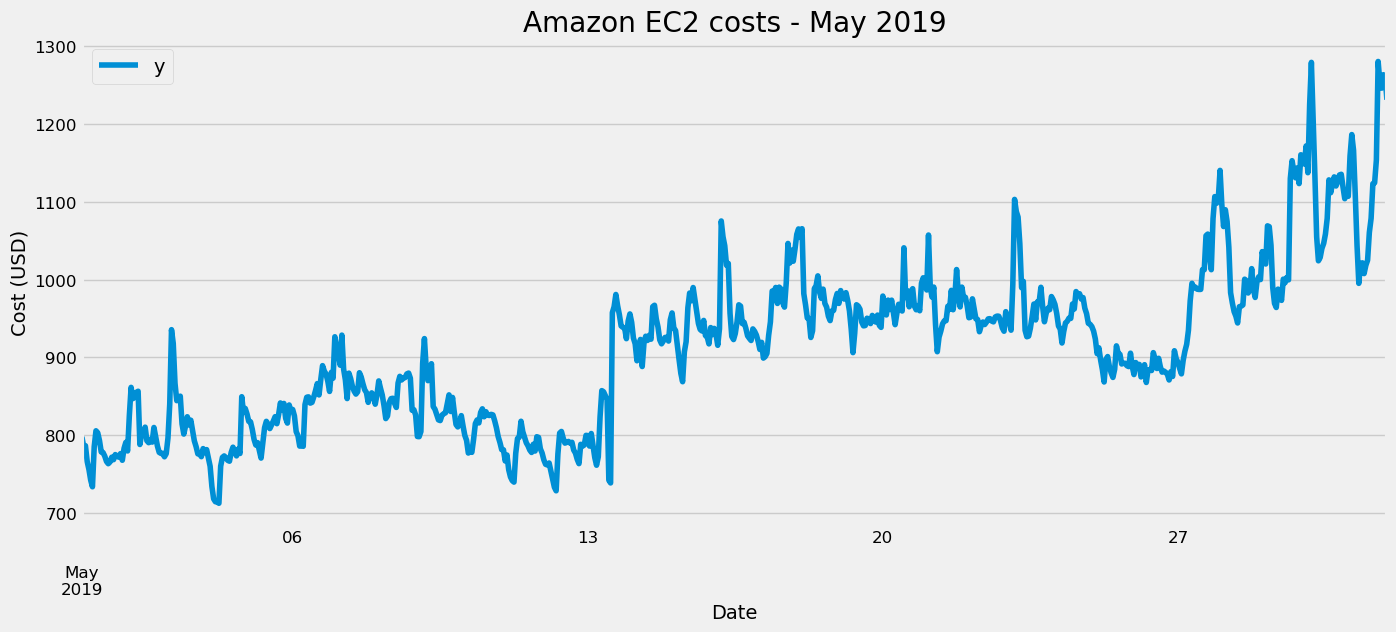

In [72]:
df_costs.plot(figsize=(15, 6))
plt.title('Amazon EC2 costs - May 2019')
plt.xlabel('Date')
plt.ylabel('Cost (USD)')
#plt.legend()
plt.show()

and then, we see how the above data looks when downsampled using an average daily value

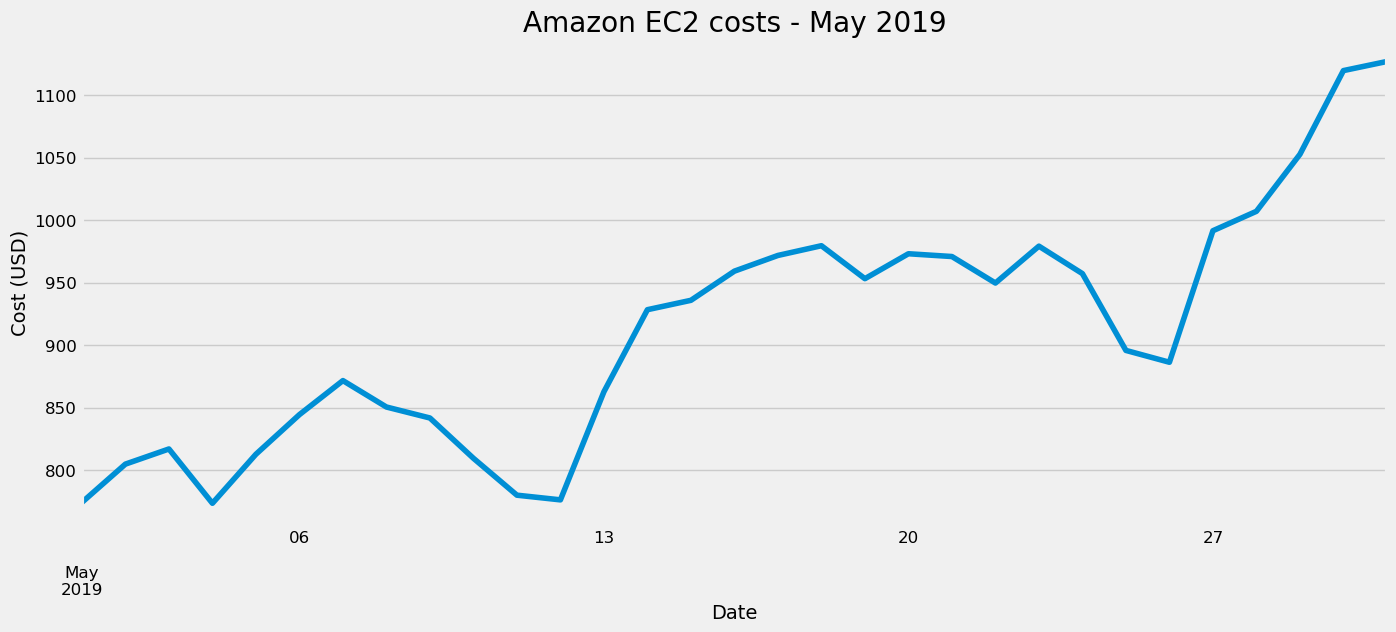

In [71]:
df_costs_monthly.plot(figsize=(15, 6))
plt.title('Amazon EC2 costs - May 2019')
plt.xlabel('Date')
plt.ylabel('Cost (USD)')
#plt.legend()
plt.show()

As we can see, data is clearly not stationary. We have a weekly seasonal pattern and a growing trend. We will apply first and seasonal differences and see how they affect stationarity of data.

#### STUDYING STATIONARITY USING DIFFERENCES

We will apply some differencing transformations in order to see wether we can bring the time series to a stationary behavior. More precisely, we will be applying first differences, seasonal differences (weekly) and a combination of both. 

In [73]:
df_costs_monthly_first_diff = df_costs_monthly.diff()
df_costs_monthly_seasonal_diff = df_costs_monthly.diff(7)
df_costs_monthly_seasonal_first_diff = df_costs_monthly_seasonal_diff.diff()

Transformed time series can be seen in what follows.

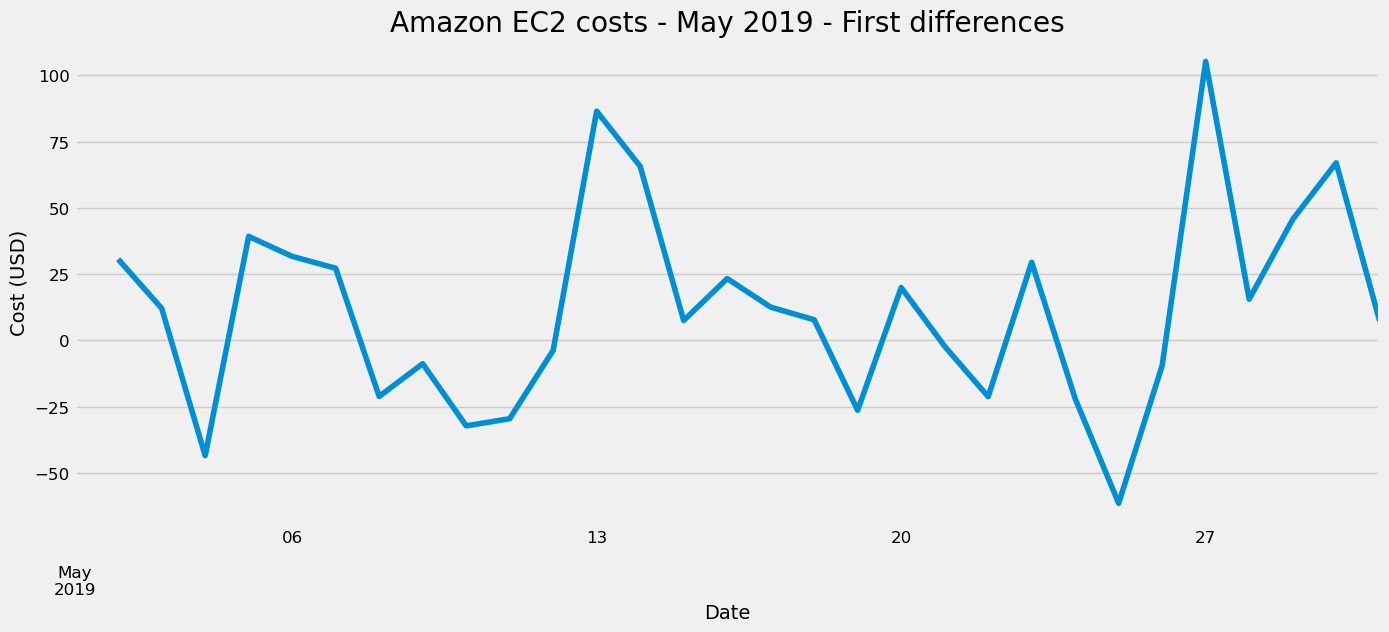

In [42]:
df_costs_monthly_first_diff.plot(figsize=(15, 6))
plt.title('Amazon EC2 costs - May 2019 - First differences')
plt.xlabel('Date')
plt.ylabel('Cost (USD)')
#plt.legend()
plt.show()

This first-differenced time series seems to be stationary. Let's perform an **ADF test** to ensure stationarity.

In [88]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df_costs_monthly_first_diff[1:])#df_costs_monthly_seasonal_first_diff[8:])

print(pvalue)

0.0005699360646698533


As we can see, we can reject $H_0$ hypothesis and claim **stationarity**. Let's see wether we can conclude something about model parameters analyzing **ACF** and **PACF**.

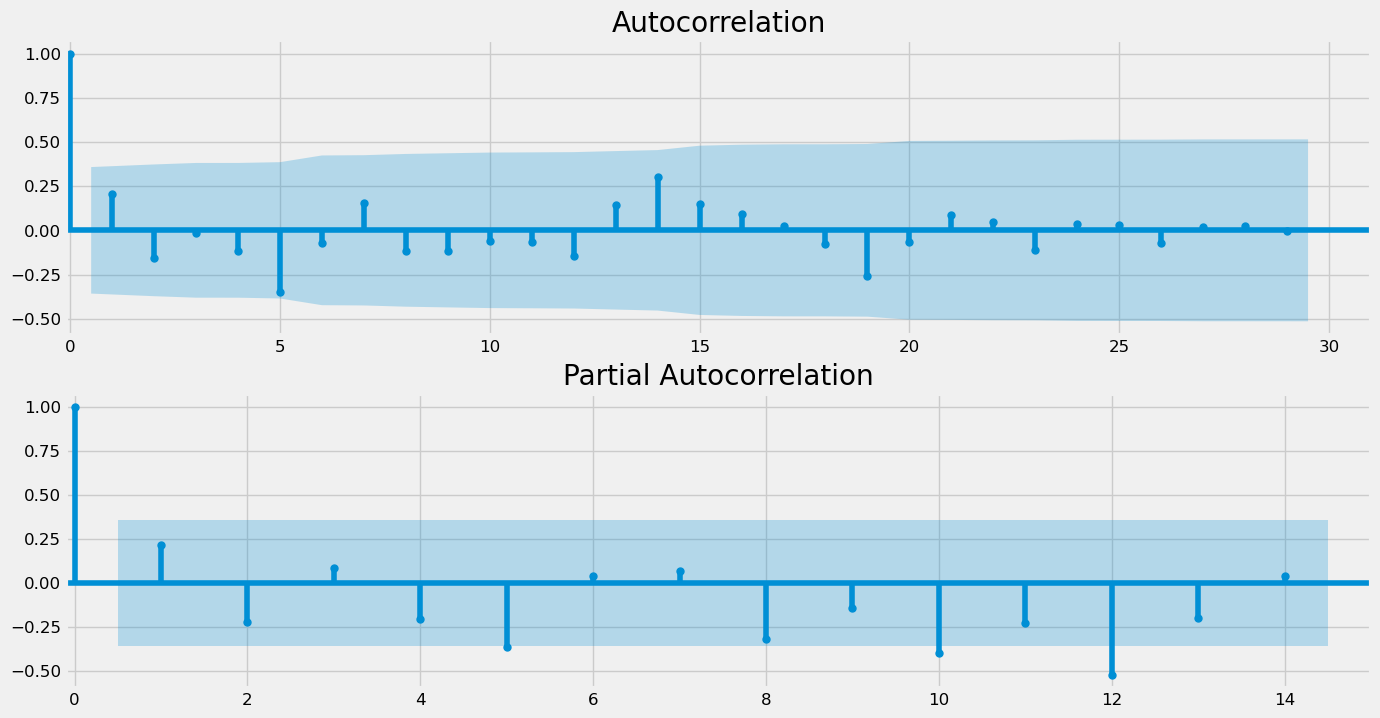

In [116]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(df_costs_monthly_first_diff.dropna(), lags=29, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_costs_monthly_first_diff.dropna(), lags=14, ax=ax[1])
ax[0].set_xlim(-0.1, 31)
ax[1].set_xlim(-0.1, 15)
plt.show()

We observe a gradually decreasing trend in the ACF plot, while PACF plot cuts immediately after 1 lag. This suggests that an **AR(1)** model could be appropriate to deal with this time series.

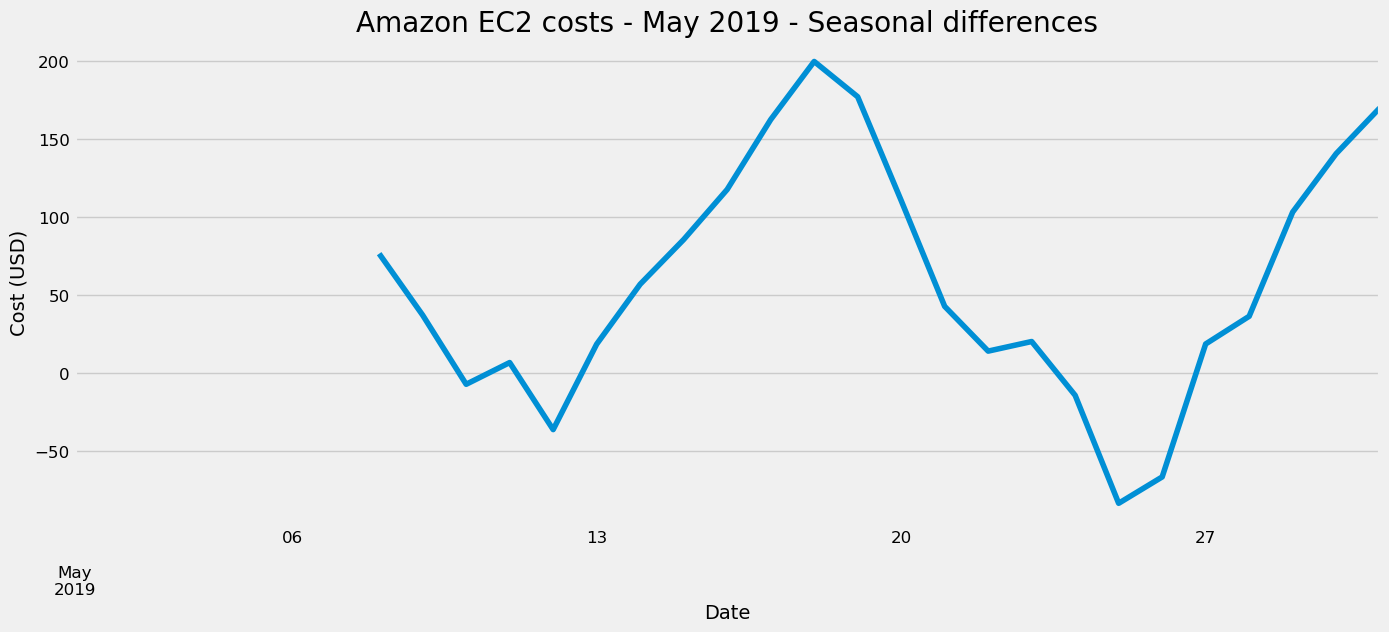

In [79]:
df_costs_monthly_seasonal_diff.plot(figsize=(15, 6))
plt.title('Amazon EC2 costs - May 2019 - Seasonal differences')
plt.xlabel('Date')
plt.ylabel('Cost (USD)')
#plt.legend()
plt.show()

Let's check stationarity again.

In [89]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df_costs_monthly_seasonal_diff[8:])

print(pvalue)

0.008283759220635586


This pvalue is a bit higher than the one before, but we could still claim stationarity. Let's see what we can conclude from ACF and PACF plots.

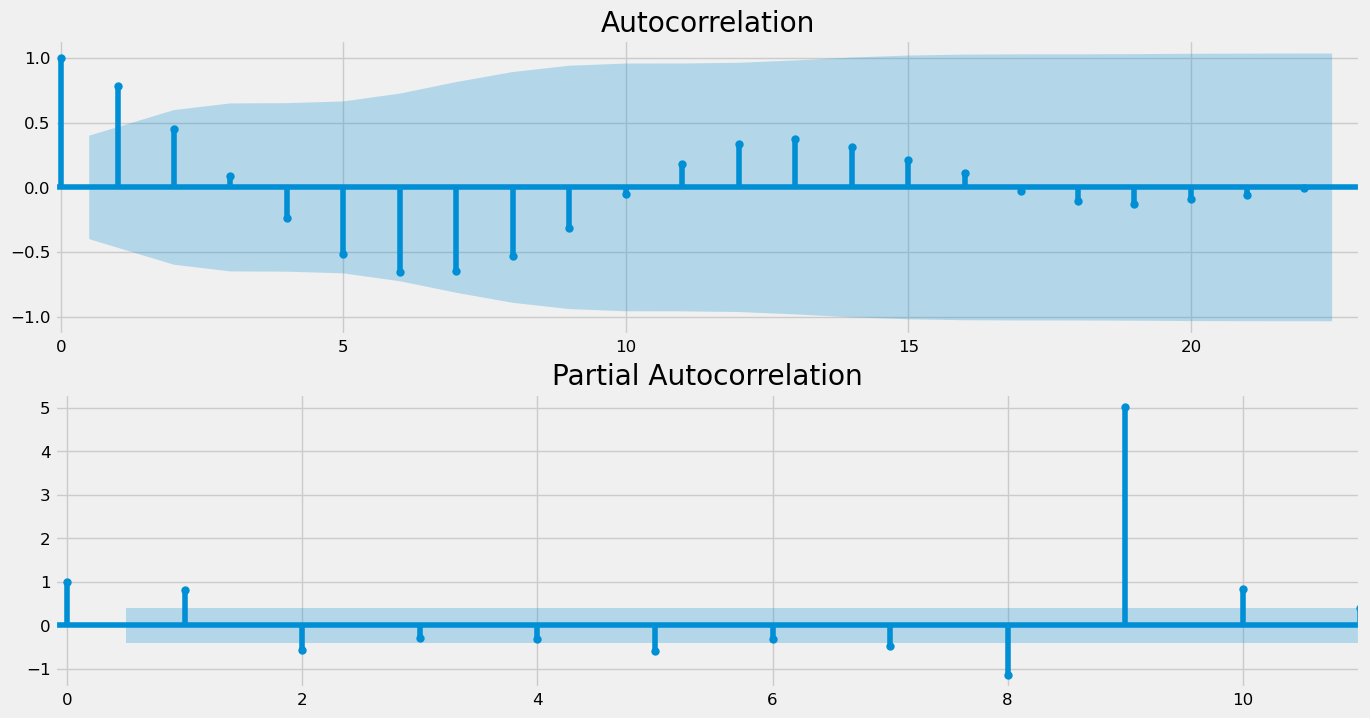

In [115]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(df_costs_monthly_seasonal_diff.dropna(), lags=22, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_costs_monthly_seasonal_diff.dropna(), lags=11, ax=ax[1])
ax[0].set_xlim(-0.1, 23)
ax[1].set_xlim(-0.1, 11)
plt.show()

Again, we have a slow decay in ACF, but PACF is less clear to interpret. **[AURELIO]**. Finally, let's analize the effect of both transformations applied together.

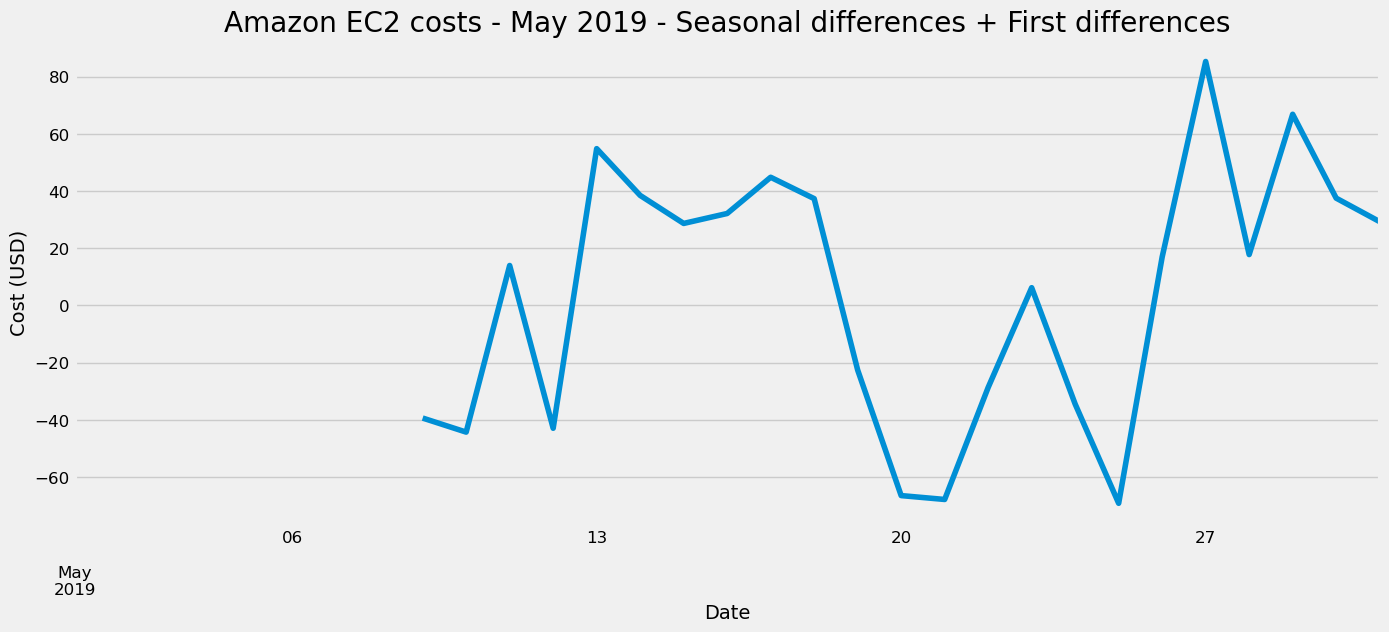

In [67]:
df_costs_monthly_seasonal_first_diff.plot(figsize=(15, 6))
plt.title('Amazon EC2 costs - May 2019 - Seasonal differences + First differences')
plt.xlabel('Date')
plt.ylabel('Cost (USD)')
#plt.legend()
plt.show()

This transformations doesn't seem to deliver a stationary time series. Let's check the results of the ADF test.

In [90]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df_costs_monthly_seasonal_first_diff[8:])

print(pvalue)

0.13809912549961395


As we can see, now we don't have the right to reject $H_0$. Therefore, we can't conclude this time series is stationary. 

After having explored the data to understand its behavior, we will perform a grid search to find the best parameters for the SARIMA model using AIC as KPI.  

## FORECASTING PROCESS
### INTRODUCTION

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA 
that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I), and moving 
average (MA) for the seasonal component of the series, as well as an additional parameter for the 
period of the seasonality.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series. Concretely, for the ARIMA part we have

* p: Trend autoregression order
* d: Trend difference order
* q: Trend moving average order

and for the seasonal elements,

* P: Seasonal autoregressive order
* D: Seasonal difference order
* Q: Seasonal moving average order
* m: The number of time steps for a single seasonal period

Having this into account, we can denote a certain SARIMA model as

**SARIMA(p,d,q)(P,D,Q)m**

### FINDING THE BEST MODEL

#### GRID SEARCH PROCESS

We will perform a grid search process for finding the set of parameters that minimizes AIC. To do that, we prepare the grid

In [93]:
# we make three ranges (0,1) and store them in p, d, q respectively
p = d = q = range(0, 2) 
# we use itertools.product to make a cartesian product of p, d, q and then we store its results in a list called pdq
pdq = list(itertools.product(p, d, q))
# we do the same for the seasonal parameters, having set m = 7 (weekly seasonal period)
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]

In [95]:
print('Examples of parameter combinations for Seasonal ARIMA...')
f"SARIMA: {pdq[0]} x {seasonal_pdq[1]} " \
f"SARIMA: {pdq[1]} x {seasonal_pdq[2]} " \
f"SARIMA: {pdq[2]} x {seasonal_pdq[0]} " \
f"SARIMA: {pdq[1]} x {seasonal_pdq[1]} "

Examples of parameter combinations for Seasonal ARIMA...


'SARIMA: (0, 0, 0) x (0, 0, 1, 7) SARIMA: (0, 0, 1) x (0, 1, 0, 7) SARIMA: (0, 1, 0) x (0, 0, 0, 7) SARIMA: (0, 0, 1) x (0, 0, 1, 7) '

and then we fit the SARIMA model for each combination of parameters in the grid, compare the AICs and choose the parameter set that minimizes it:

In [102]:
arima_parameters = []
seasonal_parameters = []
AIC = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # SARIMAX MODEL INITIALIZATION
            sarimax = sm.tsa.statespace.SARIMAX(df_costs_monthly,
                                            order=param,
                                            seasonal_order=param_seasonal)
            
            # SARIMAX MODEL FITTING
            fitted_sarimax = sarimax.fit(max_iter = 50, method = 'powell')
            
            arima_parameters.append(param)
            
            seasonal_parameters.append(param_seasonal)
            
            AIC.append(fitted_sarimax.aic)
            
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, np.round(fitted_sarimax.aic,2)))

        except:
            continue

# we obtain index for minimum AIC

min_AIC_index = AIC.index(min(AIC))

f'The optimum set of parameters for SARIMA model is [p,d,q]: {arima_parameters[min_AIC_index]}, [P,D,Q,m]: {seasonal_parameters[min_AIC_index]}. For that choice we get an AIC index of {np.round(AIC[min_AIC_index],2)}'

Optimization terminated successfully.
         Current function value: 8.239448
         Iterations: 1
         Function evaluations: 32
SARIMA(0, 0, 0),(0, 0, 0, 7) - AIC:512.85
Optimization terminated successfully.
         Current function value: 7.846187
         Iterations: 4
         Function evaluations: 108
SARIMA(0, 0, 0),(0, 0, 1, 7) - AIC:490.46
Optimization terminated successfully.
         Current function value: 4.626168
         Iterations: 2
         Function evaluations: 34
SARIMA(0, 0, 0),(0, 1, 0, 7) - AIC:288.82
Optimization terminated successfully.
         Current function value: 4.625385
         Iterations: 2
         Function evaluations: 71
SARIMA(0, 0, 0),(0, 1, 1, 7) - AIC:290.77
Optimization terminated successfully.
         Current function value: 6.486690
         Iterations: 3
         Function evaluations: 93
SARIMA(0, 0, 0),(1, 0, 0, 7) - AIC:406.17
Optimization terminated successfully.
         Current function value: 6.485611
         Iterations: 5
 

'The optimum set of parameters for SARIMA model is [p,d,q]: (0, 1, 0), [P,D,Q,m]: (1, 1, 0, 7). For that choice we get an AIC index of 232.03'

### MODEL FITTING

Having found the set of parameters that minimizes AIC, we 

In [103]:
sarimax_object = sm.tsa.statespace.SARIMAX(df_costs_monthly,
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 0, 7))
sarimax_model = sarimax_object.fit(max_iter = 100, method = 'powell')
sarimax_model.summary()

Optimization terminated successfully.
         Current function value: 3.677848
         Iterations: 2
         Function evaluations: 46


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   31
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -114.013
Date:                           Wed, 25 Aug 2021   AIC                            232.027
Time:                                   12:12:28   BIC                            234.298
Sample:                               05-01-2019   HQIC                           232.598
                                    - 05-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.7416      0.170     -4.356      0.000      -1.075      -0.408
sigma2       930.0224    442.015      2.104      0.035      63.689    1796.356
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.90   Prob(JB):                         0.49
Heteroskedasticity (H):               1.63   Skew:                            -0.08
Prob(H) (two-sided):                  0.51   Kurtosis:                         1.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### RESIDUAL ANALYSIS

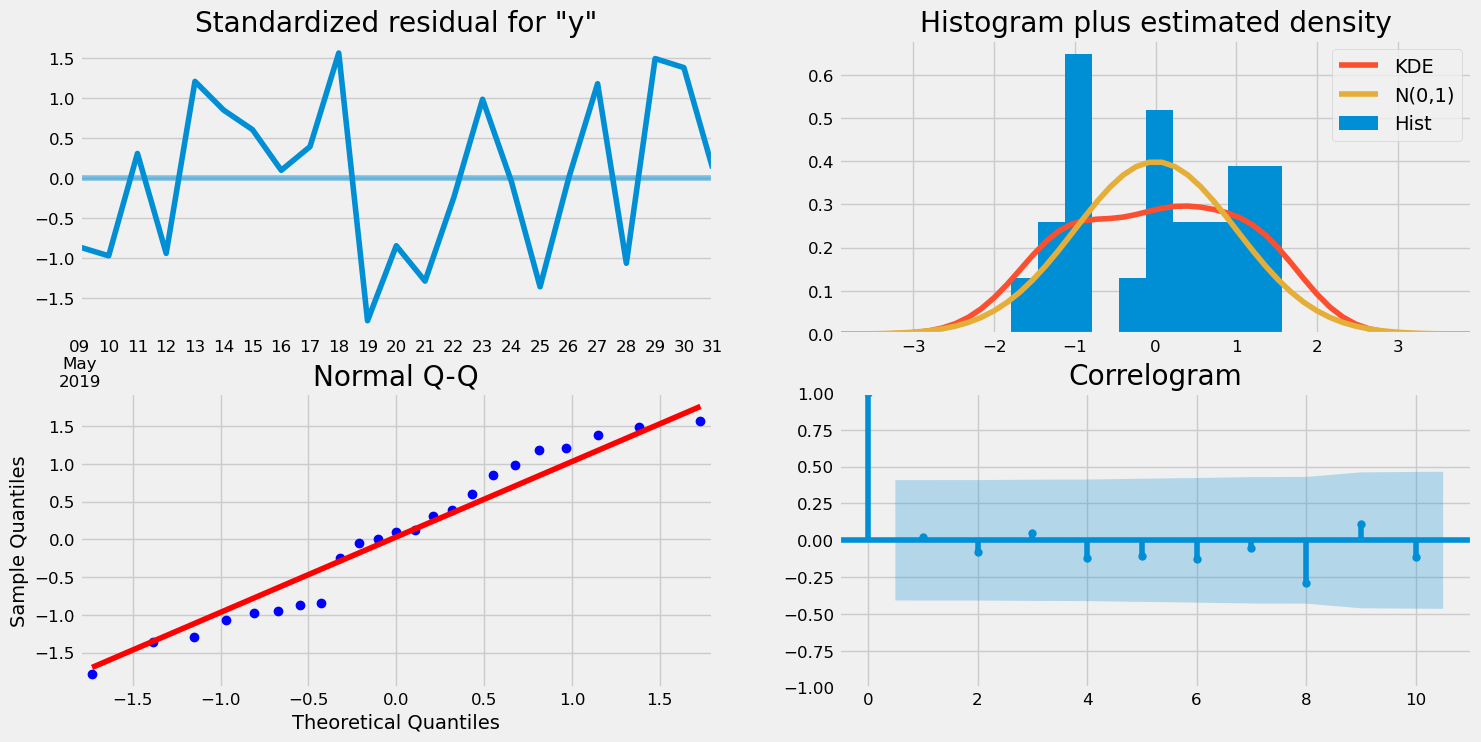

In [105]:
sarimax_model.plot_diagnostics(figsize=(16, 8))
plt.show()

As we can see in the **Residuals plot**, they seem to fluctuate around zero and also to have uniform variance. Looking at the **Density plot** we find a dsitribution that resembles a normal one, but it's not quite well defined. As per the **Normal Q-Q plot**, fluctuations around the identity line are small, signaling the absence of skewedness. Finally, the **Correlogram** or **ACF plot** seems to indicate that no correlation between residuals is present at the stablished significance level (0.05).

In order to statistically prove wether the residuals are correlated or not we can perform a Ljung-Box test (https://en.wikipedia.org/wiki/Ljung–Box_test):

In [145]:
residuals_ljungbox_test_results = sm.stats.acorr_ljungbox(sarimax_model.resid, model_df=0, lags=[10], return_df=True)
print(residuals_ljungbox_test_results)

     lb_stat  lb_pvalue
10  7.864767   0.642044


As we can see, we have the Ljung-Box statistic $Q=7.86$ and it's p-value equal to 0.642. This means that we are in position not to reject $H_0$, i.e., there is no serial correlation between residuals. 

#### LATE TAIL COMPARISON

Let's compare the model with the last week of the series to see how it performs.

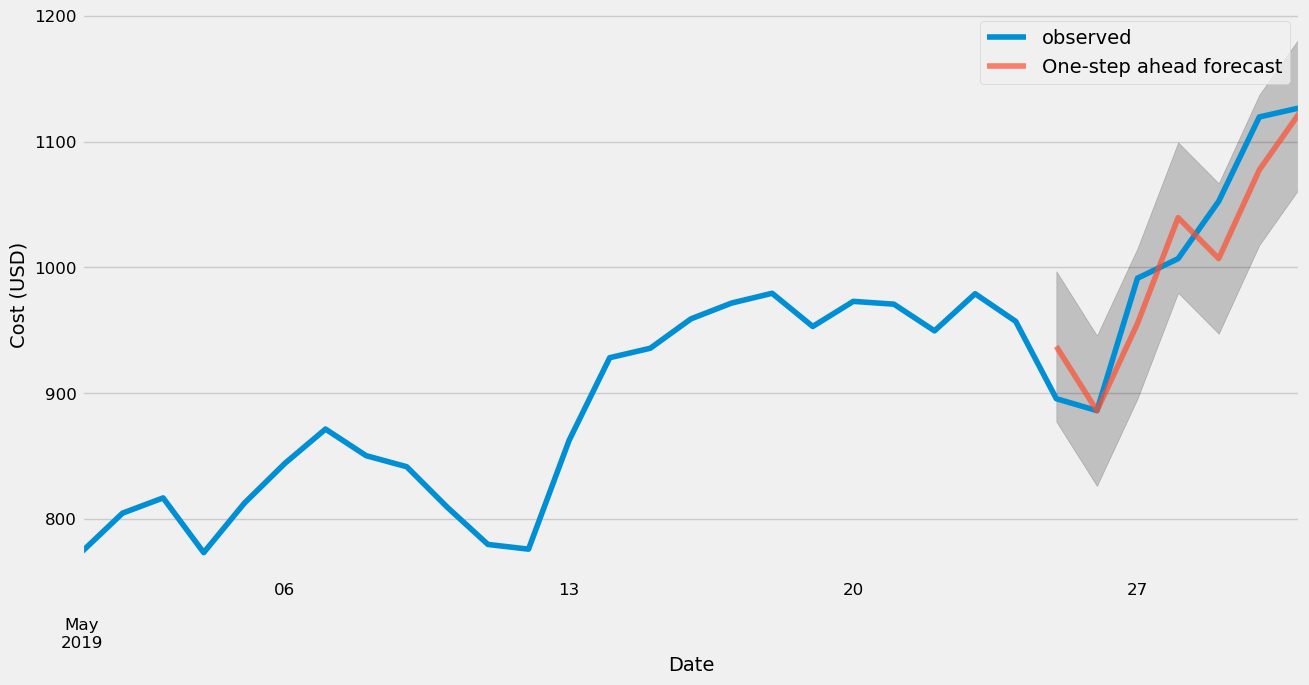

In [109]:
pred = sarimax_model.get_prediction(start=pd.to_datetime('2019-05-25'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_costs_monthly['2019-05-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Cost (USD)')
plt.legend()
plt.show()

We see its performance is acceptable.

#### FORECAST

Now that we have tested everything and we are sure where we are heading at, let's do a 1-week forecast.

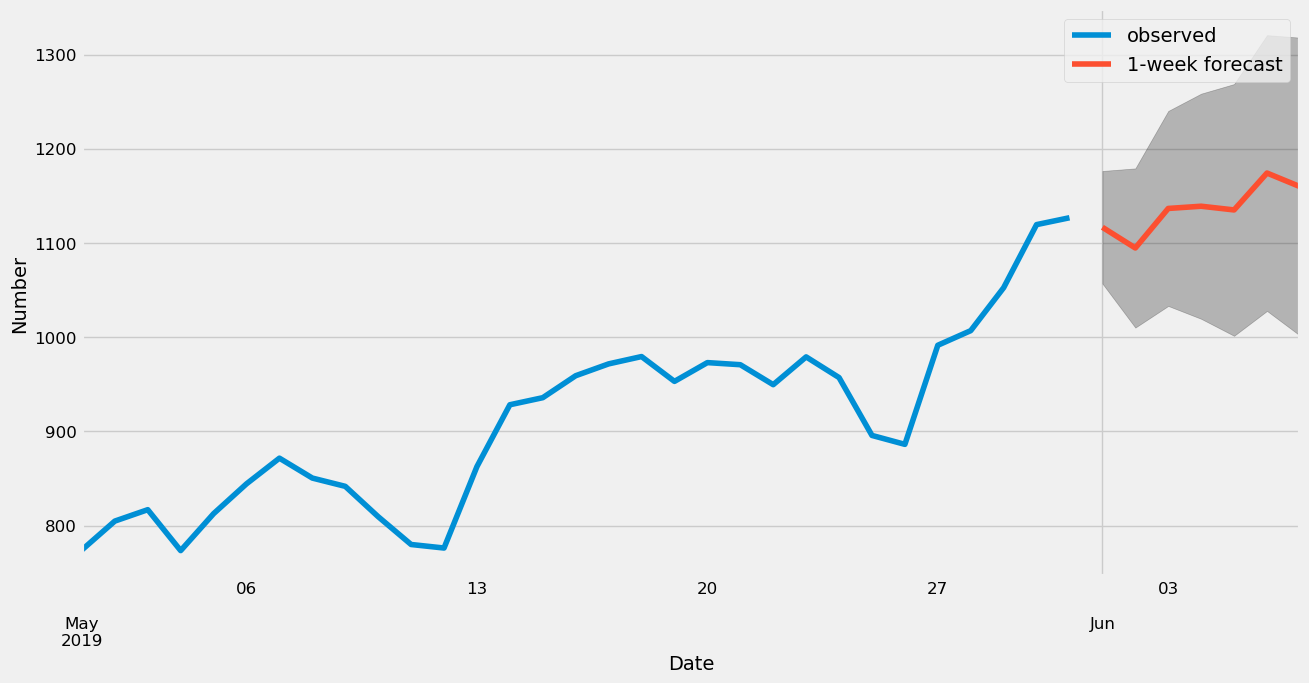

In [108]:
pred_uc = sarimax_model.get_forecast(steps=7)
pred_ci = pred_uc.conf_int()
ax = df_costs_monthly.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='1-week forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Number')
plt.legend()
plt.show()

## USING PMDARIMA PACKAGE TO AUTOMATIZE THE WHOLE PROCESS

Pmdarima (originally pyramid-arima, for the anagram of 'py' + 'arima') is a statistical library designed to fill the void in Python's time series analysis capabilities. This includes:

- The equivalent of R's auto.arima functionality
- A collection of statistical tests of stationarity and seasonality
- Time series utilities, such as differencing and inverse differencing
- Numerous endogenous and exogenous transformers and featurizers, including Box-Cox and Fourier transformations
- Seasonal time series decompositions
- Cross-validation utilities
- A rich collection of built-in time series datasets for prototyping and examples
- Scikit-learn-esque pipelines to consolidate your estimators and promote productionization

Pmdarima wraps statsmodels under the hood, but is designed with an interface that's familiar to users coming from a scikit-learn background.

### FINDING THE BEST SARIMA MODEL

In [153]:
# Seasonal - fit stepwise auto-ARIMA
import pmdarima as pm
smodel = pm.auto_arima(df_costs_monthly, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         start_d=0, max_d=1,#d=None
                         D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=False, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=242.226, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=233.965, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=238.747, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=235.958, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=235.956, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=235.853, Time=0.03 sec


/Users/homocuadratus/Projects/time-series-final-work/time-series-final-work-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,0)(2,1,1)[7]             : AIC=237.858, Time=0.21 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=232.026, Time=0.01 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=234.011, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=33907192.642, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=33907186.983, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=233.959, Time=0.03 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=234.973, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[7] intercept   : AIC=234.004, Time=0.03 sec

Best model:  ARIMA(0,1,0)(1,1,0)[7]          
Total fit time: 0.878 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   31
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -114.013
Date:                           Wed, 25 Aug 2021   AIC                            232.026
Time:                                   17:17:49   BIC                            234.297
Sample:                                        0   HQIC                           232.597
                                            - 31                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.7441      0.170     -4.384      0.000      -1.077      -0.411
sigma2       927.6328    439.360      2.111      0.035      66.503    1788.763
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.90   Prob(JB):                         0.49
Heteroskedasticity (H):               1.64   Skew:                            -0.08
Prob(H) (two-sided):                  0.50   Kurtosis:                         1.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

order=(0, 1, 0),
seasonal_order=(1, 1, 0, 7)

As we can see, the resultant model is the same we obtained before working by hand.